<a href="https://colab.research.google.com/github/mburkasov/Financial-forecasting/blob/main/Case_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPortfolioOpt
#https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import seaborn as sns

from google.colab import drive
from pandas_datareader import DataReader
from datetime import datetime
from pypfopt.efficient_frontier import EfficientFrontier


In [ ]:
assets=['AMD', 'AMED', 'AMT', 'AMZN', 'BIO', 'CDNS', 'CHD', 'CLX',
        'DG', 'EBS', 'EQIX', 'FB', 'IMMU', 'INTC', 'JNJ',
        'MCD', 'MRK', 'MSFT', 'NEE', 'PG', 'QDEL',
        'SAM', 'SBUX', 'SGEN', 'TTWO', 'V', 'WMT',
        ]

df1=pd.DataFrame()
for i in assets:
  df1[i]=DataReader(i, 'yahoo', datetime(2010,1,1), datetime(2020,11,11))['Close']

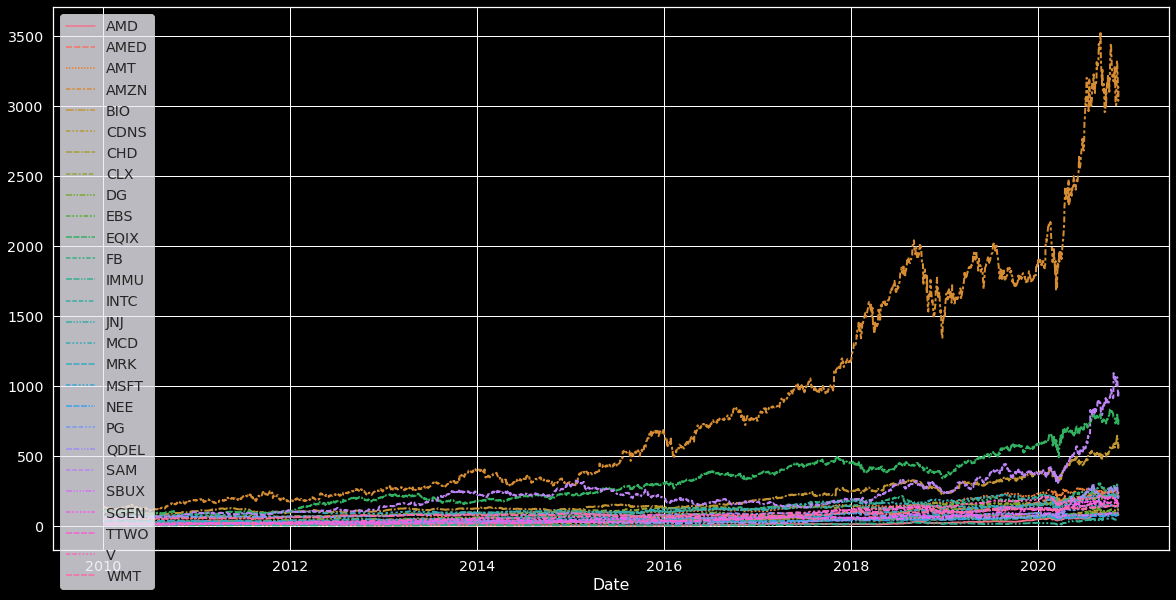

In [ ]:
#sns.set_theme()
plt.style.use("dark_background")
fig = plt.plot(figsize = (16,6))
style = {'axes.labelcolor': 'white',
                'xtick.color': 'white',
                'ytick.color': 'white',
                'legend.frameon': True,
                  'grid.color': '#121212',
                  'axes.edgecolor': '#121212',
                'axes.facecolor': '#121212',
                }

sns.set(rc = {'figure.figsize': (20,10)})
sns.set(font_scale=1)
sns.set_style(rc=style)
sns.color_palette('bright')

allreturns=df1.pct_change()
#plt.figure(figsize=(20,10))
sns.set(font_scale=1.3)

sns.lineplot(data = df1, linewidth=2)

In [ ]:
def plot_scatter(portfolio):
  #np.random.seed(7101952)
  returns = df1.iloc[0:1258].pct_change()
  mu = returns.mean()*252
  Sigma = returns.cov()*252

  num_ports = 10000
  all_weights = np.zeros((num_ports, np.shape(returns)[1]))
  ret_arr = np.zeros(num_ports)
  vol_arr = np.zeros(num_ports)
  sharpe_arr = np.zeros(num_ports)

  for x in range(num_ports):
    #Weights
    weights = np.array(np.random.random(np.shape(returns)[1]))
    weights = weights/np.sum(weights)
    #save weights
    all_weights[x,:] = weights
    #Expected return
    ret_arr[x]=np.sum(mu * weights)
    #Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
    #Sharpe ratio
    sharpe_arr[x] = (ret_arr[x])/vol_arr[x]


  plt.figure(figsize=(12,6))
  plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
  plt.colorbar(label='Sharpe ratio')
  plt.xlabel('Volatility')
  plt.ylabel('Return')
  plt.scatter(portfolio[1], portfolio[0], c='red') #red dot
  plt.show()

def dropdown(portfolio_value):
  max = -100
  min = 0
  drop = 0
  for index, row in portfolio_value.iterrows():
    if row[0] > max:
      max = row[0]
      min = row[0]
      maxdate = row.name
      mindate = row.name
    if row[0] < min:
      min = row[0]
      mindate = row.name
    if max - min > drop:
      drop = max - min
      perc = drop/max*100
      dates = [maxdate, mindate]
  print('-------------\nDropdown')
  print('Absolute value:',drop.round(2),'\nPercent:', perc.round(2),'%\nDates:', dates[0].date(), '-', dates[1].date())
  return dates

Annual return: 34.56 %
Annual volatility: 24.8 %
-------------
Dropdown
Absolute value: 89.26 
Percent: 18.43 %
Dates: 2020-05-11 - 2020-06-08


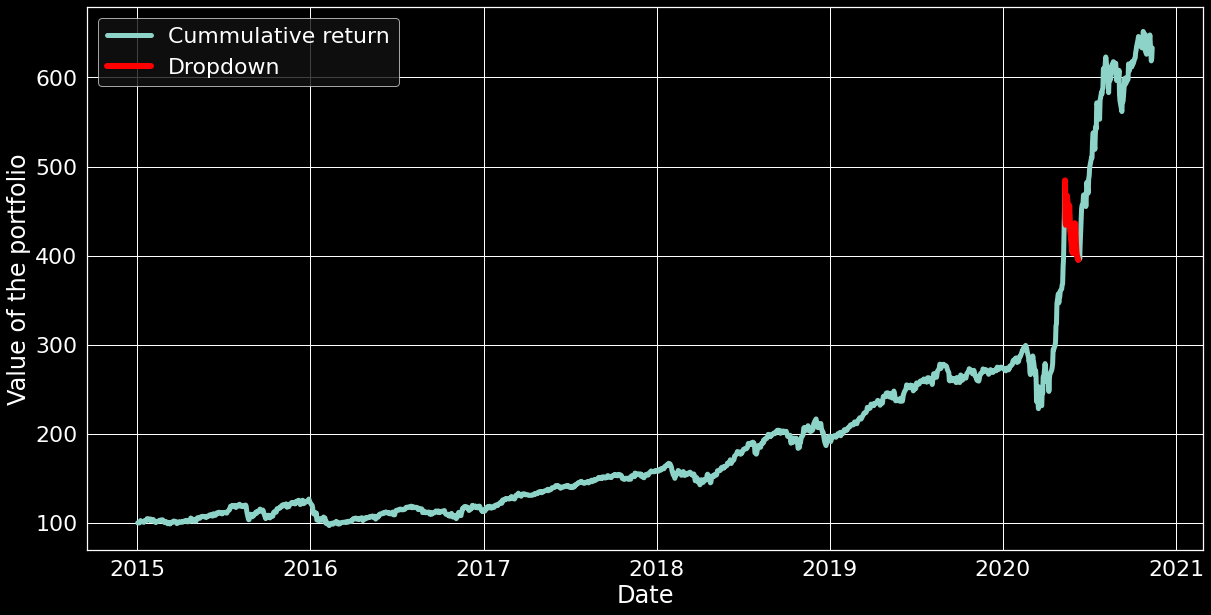

In [ ]:
actreturn = pd.DataFrame()
allweights = pd.DataFrame()
plot = pd.DataFrame(columns=['return','iv'])
#ШАГ ПЕРЕПАКОВКИ
step = 40
start = 1178
for i in range(0, len(df1.iloc[1258:]), step):
  df = df1.iloc[start+i:1258+i]
  returns = df.pct_change()
  #calculate parameters
  mu = returns.mean()*252
  Sigma = returns.cov()*252
  ef = EfficientFrontier(mu, Sigma,solver="ECOS")
  #optimisation criteria!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  #pfolio = ef.efficient_return(0.3) #по доходности
  #pfolio = ef.efficient_risk(0.13) #работает не оч особенно при маленьких значениях
  pfolio = ef.max_sharpe()
  #pfolio = ef.max_quadratic_utility()
  #pfolio = ef.min_volatility()
  #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
  #save return and volatility
  plot.loc[len(plot)] = list(ef.portfolio_performance()[0:2])
  #fill dataframes
  weights = np.array(list(pfolio.values()))
  weights = pd.Series(weights, name = allreturns.iloc[1258+i].name, index=df.columns)

  allweights = allweights.append(weights)

#returns of the original stocks
returns = df1.iloc[1258:].pct_change()
#weights of the portfolio
newweights = pd.DataFrame(allweights, index=returns.index)
newweights = newweights.fillna(method='ffill')
#the value of the portfolio
sum = 100
value = newweights.copy()
value.iloc[0] *= sum
for i in range(1,len(newweights)):
  value.iloc[i] = (value.iloc[i-1]*(returns.iloc[i]+1)).sum()*value.iloc[i]

port = pd.DataFrame(value.sum(axis=1))
#return and risk
portret = port.pct_change()
annual = round(portret[0].mean()*252*100,2)
volatility = round(np.std(portret[0],ddof=0)*np.sqrt(252)*100,2)
print('Annual return:',annual,'%')
print('Annual volatility:',volatility,'%')

#dropdown
dropdates = dropdown(port)
#graph
plt.style.use("dark_background")
fig = plt.plot(figsize = (16,6))

sns.set(rc = {'figure.figsize': (20,10)})
sns.set(font_scale=2)
sns.set_style(rc=style)
sns.color_palette('bright')



ax = sns.lineplot(data = port[0],linewidth=5,label='Cummulative return')
sns.lineplot(data = port[0].loc[dropdates[0]:dropdates[1]], color='red', linewidth=6, label='Dropdown')
ax.set(ylabel='Value of the portfolio')

l = ax.legend()
for text in l.get_texts():
    text.set_color("white")

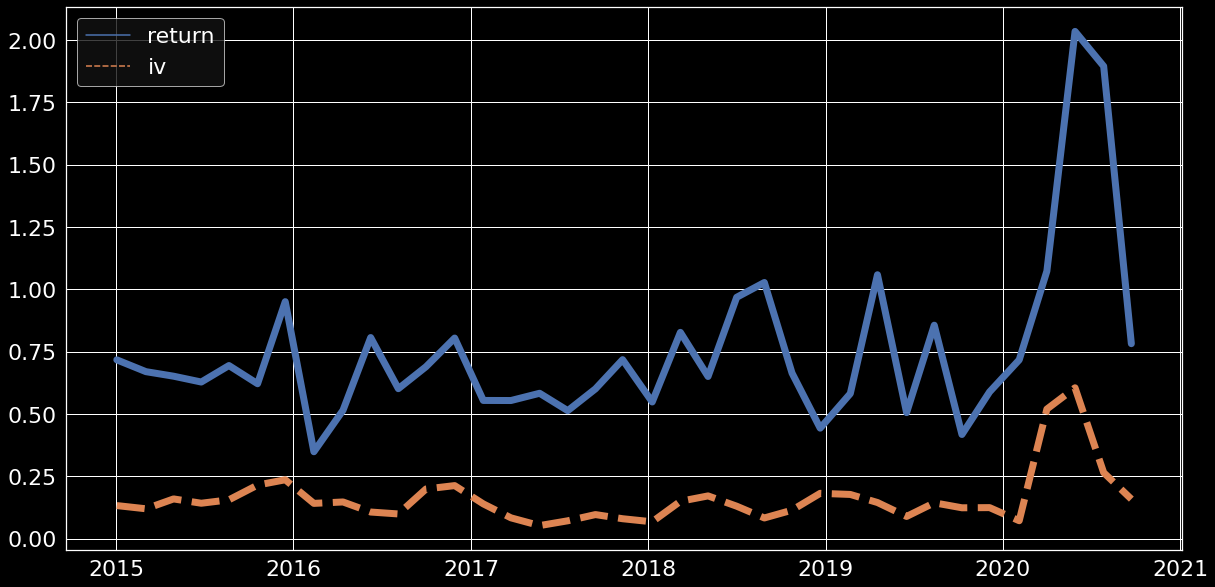

In [ ]:
plt.style.use("dark_background")
fig = plt.plot(figsize = (16,6))

sns.set(rc = {'figure.figsize': (20,10)})
sns.set(font_scale=2)
sns.set_style(rc=style)
sns.color_palette('bright')

#graph

plot.index = allweights.index

bx = sns.lineplot(data = plot, linewidth=7)

l = bx.legend()
for text in l.get_texts():
    text.set_color("white")

Mounted at /content/drive


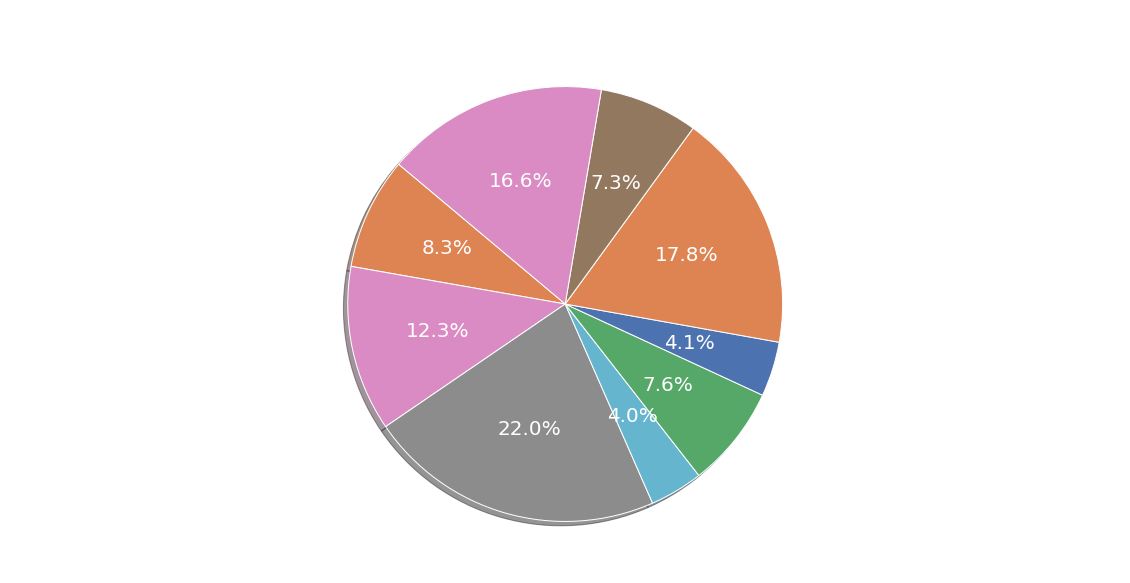

In [ ]:
#remove 0 weight portfolios
for column in allweights:
  if allweights[column].sum() < 0.001:
    allweights.pop(column)

fig, ax = plt.subplots()
palette = sns.color_palette(None, len(allweights.iloc[0]))

def update(num):
    ax.clear()
    ax.axis('equal')
    colors = []
    temp = allweights.iloc[num]
    tempc = allweights.iloc[num]
    for i in range(len(tempc)):
      item = tempc[i]
      if item < 0.01:
        temp = temp.drop(tempc.index[i])
      else:
        colors.append(palette[i])
    nums = list(temp)
    ax.pie(nums, labels = temp.index, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140, textprops={'color':"w", 'fontsize':'20'})
    ax.set_title(allweights.iloc[num].name.date(), fontsize=24, color="w")


ani = animation.FuncAnimation(fig, update, frames=range(len(allweights)), repeat=False, interval = 15000/len(allweights))

drive.mount('/content/drive')
ani.save('/content/drive/My Drive/anime/anime.mov', codec="png",
         dpi=250, bitrate=-1, 
         savefig_kwargs={'transparent': True, 'facecolor': 'none'})

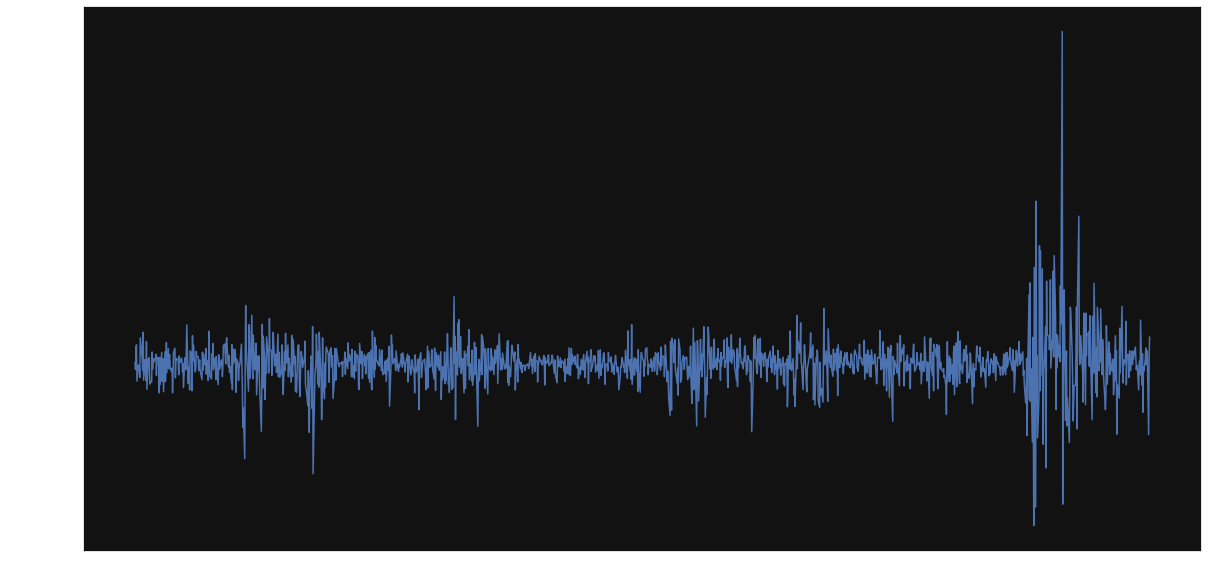

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(portret)